## AIM: Test the workflow to ensure that the CNN models can be loaded and take in user input to generate predictions
***

With the models built, now they need to be tested to make sure they can be productionalized and take in user inputs.

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import os

In [2]:
# Create a function that will take in the player of interest and the user input and return the model predictions
# Also will return the probability plot of the classes
def run_model(name, user_input):
    # Get the last name from the full name in lower case
    lastname = name.split()[1].lower()

    # Load the correct model
    model = tf.keras.models.load_model(f'saved_model/{lastname}')
    # Get the predicted probabilities
    pred_proba = model.predict(user_input)
    # Pull the max probability as the predicted pitch
    pred_pitch = np.argmax(pred_proba,axis=1)

    
    # Read in the possible pitch names
    df = pd.read_csv('pitch_names.csv', index_col = 0)
    # Store the number of different pitches as a varialbe
    pitches = len(df[df.index == name].T.dropna())
    # The number of ticks on the plot based on # of different pitches
    indices = np.arange(pitches)
    # Width of bars
    width = 0.5

    # Get the row where name equals name input
    # Drop NA columns if exists
    # Put the value to list format, default is a list inside a list of lists, use pop() to get it out of the outer list
    xnames = df[df.index == name].dropna(axis = 1).values.tolist().pop()
    
    # Convert the array of integers into the pitch names using nested np.where functions
    # For 2 pitch pitchers
    if len(xnames) == 2:
        pred_pitch = np.where(pred_pitch == 0, xnames[0], 
                                np.where(pred_pitch == 1, xnames[1], pred_pitch))
    # For 3 pitch pitchers:
    elif len(xnames) == 3: 
        pred_pitch = np.where(pred_pitch == 0, xnames[0], 
                                np.where(pred_pitch == 1, xnames[1], 
                                        np.where(pred_pitch == 2, xnames[2], pred_pitch)))
    # For 4 pitch pitchers:  
    elif len(xnames) == 4:
        pred_pitch = np.where(pred_pitch == 0, xnames[0], 
                                np.where(pred_pitch == 1, xnames[1], 
                                        np.where(pred_pitch == 2, xnames[2], 
                                                np.where(pred_pitch == 3, xnames[3], pred_pitch))))
                                 
    # Pred proba returns an array of lists, need to get just the first list of values
    # Set a color list of all light grey which is same length as number of bars
    colors = np.array(['#f0f0f0']*len(pred_proba[0]))
    # Modify the color at the index where the bar height is at the max to dark blue to stand out
    colors[pred_proba[0] == pred_proba[0].max()] = '#0f52ba'
    
    # Do the same for the edgecolors to further highlight top probability
    edgecolors = np.array(['#f0f0f0']*len(pred_proba[0]))
    edgecolors[pred_proba[0] == pred_proba[0].max()] = '#ea3c53'
    
    # Instatiate the plot
    fig, ax = plt.subplots()
    # Bar plot
    ax.bar(indices, pred_proba[0], width, edgecolor = edgecolors, linewidth='1.3', color = colors)
    
    # Add padding to improve spacing between axis, axis labels, and axis title   
    ax.set_ylabel('Predicted Probability', labelpad = 5)
    ax.set_xlabel('Pitch Type', labelpad=10)
    ax.tick_params(axis='x', which='major', pad=5)
    # Label xticks with the pitch names    
    plt.xticks(indices, xnames)
    
    # Remove some of spines for aesthetics
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_bounds(indices.min()-width/2, indices.max()+width/2)
    ax.spines['left'].set_bounds(0, pred_proba[0].max())
    # Save it to a unique timestamp --> for later
    # plt.savefig(f'C:/Users/Boyang Qiu/Desktop/Brainstation/Capstone/static/plots/prob_{now}.png')
    
    # Return a sentence summary with the probability rounded to 2 decimal places
    prediction = 'Predicted Pitch: ' + pred_pitch[0] + " ({:.2g}% predicted probability)".format(np.amax(pred_proba)*100)
    return prediction

In [24]:
# Read in the template dataframe for inputs
user = pd.read_csv('for_inputs.csv', index_col=0)
user

,on_3b,on_2b,on_1b,bat_score,fld_score,reg_season,post_season,bat_left,bat_right,b__0,...,o__0,o__1,o__2,prev__Breaking Ball,prev__Fastball,prev__None,prev__Off-speed,early,mid,late
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I noticed that for `Zack Greinke`, he has an additional pitch class called `Junk` that other pitchers do not have. This will have to be accounted for in a way that is scalable and does not affect the other players so that he can have his dataframe adjusted so it can be fed properly into the CNN.

In [20]:
# The prev_Junk column goes before the prev_None column
np.argwhere(user.columns == 'prev__None')

array([[21]], dtype=int64)

In [21]:
# Test inserting a new column there
loc = int(np.argwhere(user.columns == 'prev__None')[0][0])
user.insert(loc, 'new', 0)

In [22]:
user

,on_3b,on_2b,on_1b,bat_score,fld_score,reg_season,post_season,bat_left,bat_right,b__0,...,o__1,o__2,prev__Breaking Ball,prev__Fastball,new,prev__None,prev__Off-speed,early,mid,late
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'Predicted Pitch: Fastball (32% predicted probability)'

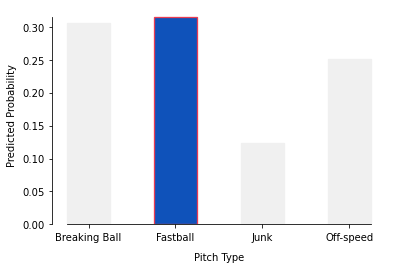

In [23]:
# Test to run
run_model('Zack Greinke', user)

'Predicted Pitch: Breaking Ball (35% predicted probability)'

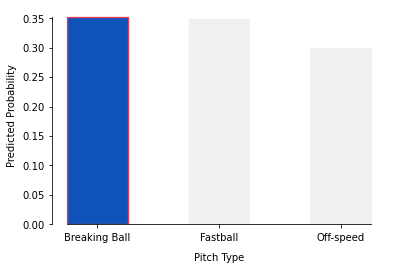

In [25]:
# Test to run for different player, but without inserting a new column
user = pd.read_csv('for_inputs.csv', index_col=0)
run_model('Max Scherzer', user)

It works! But that one unique case needs to be accounted for when somebody choosed `Zack Greinke`.

I also want a function to return a summary of the scenario inputted to the user so that they can see what they put in. I want the summary to be in "baseball English."

In [26]:
# Function to describe scenario
def scenario(user_input):
    situation = 'Pitch scenario: '

    # If clause for baserunners
    if user_input['on_3b'].all() == 1 and user_input['on_2b'].all() == 1 and user_input['on_1b'].all() == 1:
        situation = situation + 'bases loaded, '
    elif user_input['on_3b'].all() == 1 and user_input['on_1b'].all() == 1:
        situation = situation + 'runners on the corners, '
    elif user_input['on_2b'].all() == 1 and user_input['on_1b'].all() == 1:
        situation = situation + 'runners on first and second, '
    elif user_input['on_3b'].all() == 1 and user_input['on_2b'].all() == 1:
        situation = situation + 'runners on second and third, '
    elif user_input['on_3b'].all() == 1:
        situation = situation + 'runner on 3rd, '
    elif user_input['on_2b'].all() == 1:
        situation = situation + 'runner on 2nd, '
    elif user_input['on_1b'].all() == 1:
        situation = situation + 'runner on 1st, '
    else:
        situation = situation + 'bases empty, '

    # If clause for balls and strikes
    if user_input['b__3'].all() == 1 and user_input['s__2'].all() == 1:
        situation = situation + 'full count, '
    elif user_input['b__3'].all() == 1 and user_input['s__1'].all() == 1:
        situation = situation + '3-1 count, '
    elif user_input['b__3'].all() == 1 and user_input['s__0'].all() == 1:
        situation = situation + '3-0 count, '
    elif user_input['b__2'].all() == 1 and user_input['s__2'].all() == 1:
        situation = situation + '2-2 count, '
    elif user_input['b__2'].all() == 1 and user_input['s__1'].all() == 1:
        situation = situation + '2-1 count, '
    elif user_input['b__2'].all() == 1 and user_input['s__0'].all() == 1:
        situation = situation + '2-0 count, '
    elif user_input['b__1'].all() == 1 and user_input['s__2'].all() == 1:
        situation = situation + '1-2 count, '
    elif user_input['b__1'].all() == 1 and user_input['s__1'].all() == 1:
        situation = situation + '1-1 count, '
    elif user_input['b__1'].all() == 1 and user_input['s__0'].all() == 1:
        situation = situation + '1-0 count, '
    elif user_input['b__0'].all() == 1 and user_input['s__2'].all() == 1:
        situation = situation + '0-2 count, '
    elif user_input['b__0'].all() == 1 and user_input['s__1'].all() == 1:
        situation = situation + '0-1 count, '
    elif user_input['b__0'].all() == 1 and user_input['s__0'].all() == 1:
        situation = situation + '0-0 count, '

    # If clause for outs
    if user_input['o__0'].all() == 1:
        situation = situation + '0 outs, '
    elif user_input['o__1'].all() == 1:
        situation = situation + '1 out, '  
    else:
        situation = situation + '2 outs, '

    # If clause for inning
    if user_input['early'].all() == 1:
        situation = situation + 'early in the game, '
    elif user_input['mid'].all() == 1:
        situation = situation + 'middle of the game, '
    else:
        situation = situation + 'late in the game, '

    # If clause for batter hand
    if user_input['bat_left'].all() == 1:
        situation = situation + 'left-handed batter at the plate, '
    else: 
        situation = situation + 'right-handed batter at the plate, '

    # Fill in score
    # No need for if clauses here
    situation = situation + f'in a {user_input["fld_score"].values[0]}-{user_input["bat_score"].values[0]} '

    # If clause for game type
    if user_input['reg_season'].all() == 1:
        situation = situation + 'regular season game.'
    else:
        situation = situation + 'playoff game.'
    return situation

In [27]:
# Test it out
scenario(user)

'Pitch scenario: bases empty, 2 outs, late in the game, right-handed batter at the plate, in a 0-0 playoff game.'

It works for the most part. But note that even though the dataframe is all 0's, it states that there are 2 outs, there is a right handed hitter, it is late in the game, and it is a playoff game.

This is fine because of the way the clauses are written where these options are an else case. When the app is officially deployed, user MUST choose an option for those situations so there will always be an input. If the input is not for any of the options prior, then by default it will be these options, which will be correct.
***